In [1]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd

from model_code.ADFA_test import *
from model_code.NGIDS_test import *
from model_code.Discriminator import *

from sklearn.model_selection import train_test_split
from model_code.ignite_trainer import MyTrainer


from collections import OrderedDict
import time


%load_ext autoreload
%autoreload 2

import os, sys
sys.path.append(os.path.dirname(os.path.abspath(os.curdir)))

cuda = torch.device('cuda') # GPU 사용

# hyper parameter

# gensim
word_vector_size = 50 # 8~50
window_size = 1

# LSTM
adfa_batch_size = 256
n_step = 3 # 1~3
n_hidden = 64 # 8~64
LearningRate = 0.01 # 0.01~0.001
max_epoch = 400
drop_out = 0.5 #0.2~0.5
patience = 20 

# ADDA
ngids_batch_size = 256
D_NGIDS_train_num = 1
adda_max_epoch = 50
adda_LearningRate = 0.0002

dates="6_02"

### Gensim 모델 구축


In [ ]:
from model_code.ADFA_NGIDS_gensim import NGIDS_word2vec, ADFA_word2vec

NGIDS_word2vec_model = NGIDS_word2vec('./dataset/NGIDS_host_log_1-99.csv')
NGIDS_word2vec_model.make_vector(word_vector_size, save_path='./NGIDS_word2vec_'+str(word_vector_size)+'.model')

ADFA_word2vec_model = ADFA_word2vec('./dataset/ADFA-LD/')
ADFA_word2vec_model.make_vector(word_vector_size, save_path='./ADFA_word2vec_'+str(word_vector_size)+'.model')

### Gensim 모델 로드


In [2]:
import gensim

ADFA_word_model = gensim.models.Word2Vec.load('./ADFA_word2vec_'+str(word_vector_size)+'.model')
NGIDS_word_model = gensim.models.Word2Vec.load('./NGIDS_word2vec_'+str(word_vector_size)+'.model')

### 데이터 로드

In [3]:
def collate_fn(batch):

    x, y = zip(*batch)

    l = [len(i) for i in x]

    (l, i, t) = zip(*sorted(((l[i], i, (x[i], y[i])) for i in range(len(x))), reverse=True))
    (x, y) = zip(*t)

    l = torch.tensor(l)
    pack = nn.utils.rnn.pad_sequence(x, batch_first=True).to(cuda)
    y = torch.stack(y).to(cuda)

    return ((l, pack), y)


import pickle, gzip

slices = 111
X_train_add = "./shuffle_datas/ADFA_X_train_"+str(slices)+"_"+dates+".pkl"
y_train_add = "./shuffle_datas/ADFA_y_train_"+str(slices)+"_"+dates+".pkl"

X_vali_add = "./shuffle_datas/ADFA_X_vali_"+str(slices)+"_"+dates+".pkl"
y_vali_add = "./shuffle_datas/ADFA_y_vali_"+str(slices)+"_"+dates+".pkl"

X_test_add = "./shuffle_datas/ADFA_X_test_"+str(slices)+"_"+dates+".pkl"
y_test_add = "./shuffle_datas/ADFA_y_test_"+str(slices)+"_"+dates+".pkl"

def load_data(X_add, y_add):
    with gzip.open(X_add, 'rb') as f:
        X = pickle.load(f)
    with gzip.open(y_add, 'rb') as f:
        y = pickle.load(f)
    return X, y

def preprocess_y(y_data):
    label_dict = dict()
    for i in range(8):
        if i == 0:
            label_dict[i] = 0
        else:
            label_dict[i] = 1
#     tmp = np.argmax(y_data, axis=1)
    tmp = pd.Series(y_data).map(label_dict).values
    return np.asarray(tmp)


X_train, y_train = load_data(X_train_add, y_train_add)
X_vali, y_vali = load_data(X_vali_add, y_vali_add)
X_test, y_test = load_data(X_test_add, y_test_add)
y_train = preprocess_y(y_train)
y_vali = preprocess_y(y_vali)
y_test = preprocess_y(y_test)


ADFA_loader = DataLoader(ADFA_Dataset(X_train, y_train, ADFA_word_model.wv.key_to_index), 
                         batch_size=adfa_batch_size, collate_fn=collate_fn, shuffle = True)
ADFA_test_loader = DataLoader(ADFA_Dataset(X_test, y_test, ADFA_word_model.wv.key_to_index), 
                              batch_size=adfa_batch_size, collate_fn=collate_fn, shuffle = True)
ADFA_vali_loader = DataLoader(ADFA_Dataset(X_vali, y_vali, ADFA_word_model.wv.key_to_index), 
                              batch_size=adfa_batch_size, collate_fn=collate_fn, shuffle = True)

NGIDS_reader = NGIDS_Reader()
n_X_train, n_y_train, n_X_vali, n_y_vali, n_X_test, n_y_test = NGIDS_reader.data_split()

NGIDS_train_loader = DataLoader(NGIDS_Dataset(n_X_train, n_y_train, NGIDS_word_model.wv.key_to_index), 
                          batch_size=ngids_batch_size, collate_fn=collate_fn, shuffle = True)
NGIDS_vali_loader = DataLoader(NGIDS_Dataset(n_X_vali, n_y_vali, NGIDS_word_model.wv.key_to_index), 
                               batch_size=ngids_batch_size, collate_fn=collate_fn)
NGIDS_test_loader = DataLoader(NGIDS_Dataset(n_X_test, n_y_test, NGIDS_word_model.wv.key_to_index), 
                               batch_size=ngids_batch_size, collate_fn=collate_fn)


Training Results - Epoch[1]
Loss: 0.0840
Accuracy: 0.9484
Precision: 0.0000
Recall: 0.0000
ROC_AUC: 0.5000

Validation Results - Epoch[1]
Loss: 0.0849
Accuracy: 0.9482
Precision: 0.0000
Recall: 0.0000
ROC_AUC: 0.5000

Training Results - Epoch[2]
Loss: 0.0822
Accuracy: 0.9484
Precision: 0.0000
Recall: 0.0000
ROC_AUC: 0.5000

Validation Results - Epoch[2]
Loss: 0.0828
Accuracy: 0.9482
Precision: 0.0000
Recall: 0.0000
ROC_AUC: 0.5000

Training Results - Epoch[3]
Loss: 0.0820
Accuracy: 0.9484
Precision: 0.0000
Recall: 0.0000
ROC_AUC: 0.5000

Validation Results - Epoch[3]
Loss: 0.0827
Accuracy: 0.9482
Precision: 0.0000
Recall: 0.0000
ROC_AUC: 0.5000

Training Results - Epoch[4]
Loss: 0.0820
Accuracy: 0.9484
Precision: 0.0000
Recall: 0.0000
ROC_AUC: 0.5000

Validation Results - Epoch[4]
Loss: 0.0832
Accuracy: 0.9482
Precision: 0.0000
Recall: 0.0000
ROC_AUC: 0.5000

Training Results - Epoch[5]
Loss: 0.0687
Accuracy: 0.9647
Precision: 0.7956
Recall: 0.4256
ROC_AUC: 0.7098

Validation Results -

Validation Results - Epoch[38]
Loss: 0.0284
Accuracy: 0.9879
Precision: 0.9236
Recall: 0.8357
ROC_AUC: 0.9159

Training Results - Epoch[39]
Loss: 0.0318
Accuracy: 0.9899
Precision: 0.9427
Recall: 0.8558
ROC_AUC: 0.9265

Validation Results - Epoch[39]
Loss: 0.0333
Accuracy: 0.9897
Precision: 0.9357
Recall: 0.8607
ROC_AUC: 0.9287

Training Results - Epoch[40]
Loss: 0.1200
Accuracy: 0.9748
Precision: 0.9277
Recall: 0.5550
ROC_AUC: 0.7763

Validation Results - Epoch[40]
Loss: 0.1247
Accuracy: 0.9728
Precision: 0.9044
Recall: 0.5311
ROC_AUC: 0.7640

Training Results - Epoch[41]
Loss: 0.0632
Accuracy: 0.9651
Precision: 0.9349
Recall: 0.3467
ROC_AUC: 0.6727

Validation Results - Epoch[41]
Loss: 0.0648
Accuracy: 0.9636
Precision: 0.9044
Recall: 0.3317
ROC_AUC: 0.6649

Training Results - Epoch[42]
Loss: 0.0952
Accuracy: 0.9721
Precision: 0.9217
Recall: 0.5017
ROC_AUC: 0.7497

Validation Results - Epoch[42]
Loss: 0.1064
Accuracy: 0.9693
Precision: 0.8762
Recall: 0.4749
ROC_AUC: 0.7356

Training 

2022-06-05 02:42:57,900 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Validation Results - Epoch[45]
Loss: 0.0245
Accuracy: 0.9921
Precision: 0.8908
Recall: 0.9649
ROC_AUC: 0.9792



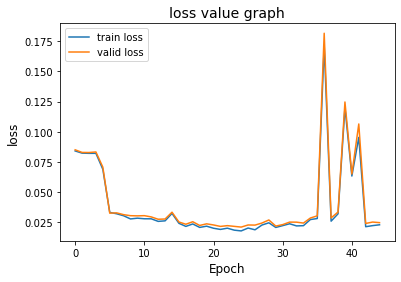

In [4]:
NGIDS_model = nn.Sequential(OrderedDict([
            ('NGIDS_LSTM', NGIDS_LSTM(word_vector_size, NGIDS_word_model.wv.vectors, n_hidden, n_step, dropout_p = drop_out)),
            ('NGIDS_LINEAR', NGIDS_LINEAR(n_hidden))
            ])).cuda()

optimizer = optim.Adam(NGIDS_model.parameters(), lr=LearningRate)
loss_func = nn.CrossEntropyLoss() 

trainer = MyTrainer(NGIDS_model, optimizer, loss_func, NGIDS_train_loader, NGIDS_vali_loader, patience)

trainer.run(max_epoch)


trainer.print_loss_graph("./result_image/lstm_weight_share_NGIDS_"+str(slices)+"_"+str(word_vector_size)+"d"+str(LearningRate).replace(".", "")+"LR_"+str(drop_out).replace(".","")+"Drop"+"_epoch"+str(max_epoch)+"_ignite_"+dates+"_ws_"+str(window_size)+"_layer_"+str(n_step))
torch.save(NGIDS_model.state_dict(), "./lstm_weight_share_NGIDS_"+str(slices)+"_"+str(word_vector_size)+"d"+str(LearningRate).replace(".", "")+"LR_"+str(drop_out).replace(".","")+"Drop"+"_epoch"+str(max_epoch)+"_ignite_"+dates+"_ws_"+str(window_size)+"_layer_"+str(n_step)+"_model.model")


###  ADDA 단계 학습 및 에폭 별 eval

In [12]:
def G_epoch_eval(G, NGIDS_model, ADFA_test_loader):
    
    NGIDS_Classifier = NGIDS_model.get_submodule('NGIDS_LINEAR')

    G.eval()
    NGIDS_Classifier.eval()

    
    model = nn.Sequential(G, NGIDS_Classifier).cuda()

    TP = 0
    FP = 0
    FN = 0
    TN = 0

    with torch.no_grad():

         for iidx, i in enumerate(ADFA_test_loader):
            batch_x, batch_y = i

            out = model(batch_x)

            for idx, j in enumerate(out) :

                if j[0] > j[1]:
                    result = 0
                else :
                    result = 1

                if batch_y[idx] == 1:
                    if result == 1:
                        TP += 1
                    else :
                        FN += 1                        
                else :
                    if result == 1 :
                        FP += 1
                    else :
                        TN += 1


    accuracy = (TP + TN)/(TP + FN + FP + TN)
    recall = TP/(FN+TP)

    print(f"Test accuacy : {accuracy}")
    print(f"Test Recall : {recall}")
    return recall

In [16]:
NGIDS_model = nn.Sequential(OrderedDict([
            ('NGIDS_LSTM', NGIDS_LSTM(word_vector_size, NGIDS_word_model.wv.vectors, n_hidden, n_step, dropout_p = drop_out)),
            ('NGIDS_LINEAR', NGIDS_LINEAR(n_hidden))
            ])).cuda()

NGIDS_model.load_state_dict(torch.load("./lstm_weight_share_NGIDS_"+str(slices)+"_"+str(word_vector_size)+"d"+str(LearningRate).replace(".", "")+"LR_"+str(drop_out).replace(".","")+"Drop"+"_epoch"+str(max_epoch)+"_ignite_"+dates+"_ws_"+str(window_size)+"_layer_"+str(n_step)+"_model.model"))

NGIDS_sub_model = NGIDS_model.get_submodule('NGIDS_LSTM')
NGIDS_sub_model.eval()
NGIDS_sub_model.cuda()

G = ADFA_LSTM(word_vector_size, ADFA_word_model.wv.vectors, n_hidden, n_step, adda_LearningRate, dropout_p = drop_out)
max_G = ADFA_LSTM(word_vector_size, ADFA_word_model.wv.vectors, n_hidden, n_step, adda_LearningRate, dropout_p = drop_out)

D = Discriminator(n_hidden, LearningRate = adda_LearningRate)
G.lstm.load_state_dict(NGIDS_sub_model.lstm.state_dict())

G.cuda()
D.cuda()

G.train()
D.train()

torch.backends.cudnn.enabled = False

max_recall = -1

'''
G.load_state_dict(torch.load("./both_NGIDS_to_ADFA_"+str(word_vector_size)+"d_epoch"+'100'+"_ignite_"+dates+"_model.model"))
D.load_state_dict(torch.load("./both_Discriminator_"+str(word_vector_size)+"d_epoch"+'100'+"_ignite_"+dates+"_model.model"))
'''

loss_func = nn.CrossEntropyLoss()
d_optim = optim.Adam(D.parameters(), lr=adda_LearningRate)
g_optim = optim.Adam(G.parameters(), lr=adda_LearningRate)

d_losses = []
g_losses = []

n_iter = min(len(NGIDS_train_loader), len(ADFA_loader))

for epoch in range(adda_max_epoch):
    print ("epoch = ", epoch + 1)
    
    source_iter = iter(NGIDS_train_loader)
    target_iter = iter(ADFA_loader)    
    
    d_loss_sum = 0
    g_loss_sum = 0
    
    for i in range(n_iter) :
        source_data, _ = next(source_iter)
        target_data, _ = next(target_iter)
        
        if len(source_data[0]) != len(target_data[0]):
               continue
        
        D_input_source = NGIDS_sub_model(source_data)
        D_input_target = G(target_data)

        D_output_source = D(D_input_source)
        D_output_target = D(D_input_target)        
        
        D_target_source = torch.tensor([1] * len(source_data[0]), dtype=torch.long).cuda()
        D_target_target = torch.tensor([0] * len(source_data[0]), dtype=torch.long).cuda()

        D_output = torch.cat([D_output_source, D_output_target], dim=0)
        D_target = torch.cat([D_target_source, D_target_target], dim=0)
        
        d_loss = loss_func(D_output, D_target)
        
        d_optim.zero_grad()
        d_loss.backward()
        d_optim.step()
        
        d_loss_sum += d_loss
        
        # target train
        D_input_target = G(target_data)
        D_output_target = D(D_input_target)
        
        g_loss = loss_func(D_output_target, D_target_source)
        
        g_optim.zero_grad()
        g_loss.backward()
        g_optim.step()
 
        g_loss_sum += g_loss
    

    d_loss = d_loss_sum / n_iter
    g_loss = g_loss_sum / n_iter
    
    d_losses.append(d_loss.detach().cpu())
    g_losses.append(g_loss.detach().cpu())
    
    print(f"D_loss : {d_loss:.4f} / G_loss : {g_loss:.4f}")
    recall = G_epoch_eval(G, NGIDS_model, ADFA_test_loader)
    
    if max_recall < recall :
        max_recall = recall
        max_G.load_state_dict(G.state_dict())
        
    
torch.save(max_G.state_dict(), "./lstm_weight_ADFA_to_NGIDS_"+str(slices)+"_"+str(word_vector_size)+"d_epoch"+str(adda_max_epoch)+"_ignite_"+dates+"_ws_"+str(window_size)+"_layer_"+str(n_step)+"_model.model")
torch.save(D.state_dict(), "./lstm_weight_ADFA_to_NGIDS_Discriminator_"+str(slices)+"_"+str(word_vector_size)+"d_epoch"+str(adda_max_epoch)+"_ignite_"+dates+"_ws_"+str(window_size)+"_layer_"+str(n_step)+"_model.model")

epoch =  1
D_loss : 0.6089 / G_loss : 0.6733
Test accuacy : 0.572986577181208
Test Recall : 0.27631578947368424
epoch =  2
D_loss : 0.5794 / G_loss : 0.6964
Test accuacy : 0.7692953020134228
Test Recall : 0.21710526315789475
epoch =  3
D_loss : 0.5555 / G_loss : 0.6960
Test accuacy : 0.8112416107382551
Test Recall : 0.1513157894736842
epoch =  4
D_loss : 0.5299 / G_loss : 0.6916
Test accuacy : 0.8355704697986577
Test Recall : 0.13157894736842105
epoch =  5
D_loss : 0.5008 / G_loss : 0.6924
Test accuacy : 0.8313758389261745
Test Recall : 0.1118421052631579
epoch =  6
D_loss : 0.4669 / G_loss : 0.7041
Test accuacy : 0.8389261744966443
Test Recall : 0.11842105263157894
epoch =  7
D_loss : 0.4299 / G_loss : 0.7256
Test accuacy : 0.8406040268456376
Test Recall : 0.09868421052631579
epoch =  8
D_loss : 0.3887 / G_loss : 0.7607
Test accuacy : 0.8439597315436241
Test Recall : 0.09868421052631579
epoch =  9
D_loss : 0.3484 / G_loss : 0.8060
Test accuacy : 0.8548657718120806
Test Recall : 0.0921

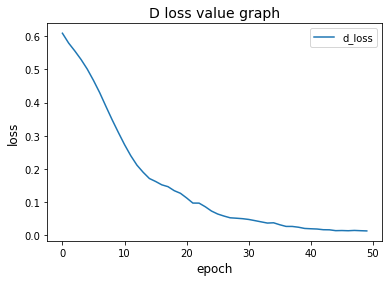

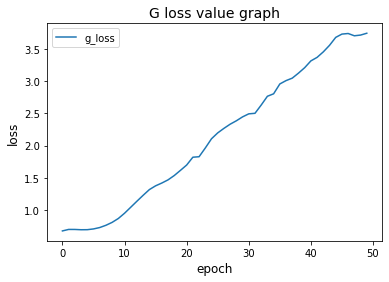

In [17]:
plt.plot(d_losses, label='d_loss')
plt.legend()
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.title("D loss value graph", fontsize=14)
plt.show()

plt.plot(g_losses, label='g_loss')
plt.legend()
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.title("G loss value graph", fontsize=14)
plt.show()
